## Step 1: Data Preprocessing

In [1]:
#Install required libraries
%pip install opencv-python pandas albumentations tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import libraries
import os
import cv2
import pandas as pd
import numpy as np
import albumentations as A
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [3]:
#Set paths(Configuration)
RAW_IMG_DIR = "raw_images"
PROCESSED_IMG_DIR = "processed_images"
FACES_CSV = "faces.csv"
OUTPUT_CSV = "processed_annotations.csv"
TARGET_SIZE = 224

os.makedirs(PROCESSED_IMG_DIR, exist_ok=True)

In [4]:
#Load and clean the annotation data
df = pd.read_csv(FACES_CSV)           #load csv
df.drop_duplicates(inplace=True)      #Remove duplicates rows
df.dropna(inplace=True)               #Remove missing rows
df.head()

image_name  width  height   x0   y0    x1   y1
0  00001722.jpg   1333    2000  490  320   687  664
1  00001044.jpg   2000    1333  791  119  1200  436
2  00001050.jpg    667    1000  304  155   407  331
3  00001736.jpg    626     417  147   14   519  303
4  00003121.jpg    626     418  462   60   599  166

In [5]:
#Define augmentations
augmentations = A.Compose([
    A.HorizontalFlip(p=1.0),
    A.Rotate(limit=10, p=1.0),
    A.RandomBrightnessContrast(p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [6]:
#Preprocessing loop
processed_data = []
#Preprocess Each Image
for _, row in tqdm(df.iterrows(), total=len(df)):
    img_name, orig_w, orig_h, x0, y0, x1, y1 = row[['image_name', 'width', 'height', 'x0', 'y0', 'x1', 'y1']]
    img_path = os.path.join(RAW_IMG_DIR, img_name)

    if not os.path.exists(img_path):
        print(f"Missing: {img_name}")
        continue
# Load image
    img = cv2.imread(img_path)
    if img is None:
        continue
 # Resize image
    img_resized = cv2.resize(img, (TARGET_SIZE, TARGET_SIZE))
    x_scale = TARGET_SIZE / orig_w
    y_scale = TARGET_SIZE / orig_h
# Resize bbox
    x0_new, x1_new = int(x0 * x_scale), int(x1 * x_scale)
    y0_new, y1_new = int(y0 * y_scale), int(y1 * y_scale)
# Save resized image
    new_img_name = img_name
    cv2.imwrite(os.path.join(PROCESSED_IMG_DIR, new_img_name), img_resized)
# Store annotation
    processed_data.append({
        "image_name": new_img_name,
        "width": TARGET_SIZE,
        "height": TARGET_SIZE,
        "x0": x0_new,
        "y0": y0_new,
        "x1": x1_new,
        "y1": y1_new,
        "is_augmented": False
    })
# Apply Augmentations
    for i, aug in enumerate(augmentations.transforms):
        aug_pipeline = A.Compose(
            [aug],
            bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'])
        )

        try:
            augmented = aug_pipeline(image=img_resized, bboxes=[[x0_new, y0_new, x1_new, y1_new]], class_labels=["face"])
            aug_img = augmented['image']
            aug_bbox = augmented['bboxes'][0]
        except Exception as e:
            print(f"Augmentation failed for {img_name} with {aug}: {e}")
            continue

        aug_img_name = f"{img_name.split('.')[0]}_aug{i}.jpg"
        cv2.imwrite(os.path.join(PROCESSED_IMG_DIR, aug_img_name), aug_img)

        processed_data.append({
            "image_name": aug_img_name,
            "width": TARGET_SIZE,
            "height": TARGET_SIZE,
            "x0": int(aug_bbox[0]),
            "y0": int(aug_bbox[1]),
            "x1": int(aug_bbox[2]),
            "y1": int(aug_bbox[3]),
            "is_augmented": True
        })

  0%|          | 0/3350 [00:00<?, ?it/s]

f:\FINAL_PROJECT_HFOD\.venv\Lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
f:\FINAL_PROJECT_HFOD\.venv\Lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
f:\FINAL_PROJECT_HFOD\.venv\Lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
f:\FINAL_PROJECT_HFOD\.venv\Lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
f:\FINAL_PROJECT_HFOD\.venv\Lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
f:\FINAL_PROJECT_HFOD\.venv\Lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bbo

In [7]:
#Save Final Processed CSV 
processed_df = pd.DataFrame(processed_data)
processed_df.to_csv(OUTPUT_CSV, index=False)
print("Preprocessing Complete.")

Preprocessing Complete.


In [8]:
# DONE!
# Now you have:
# Preprocessed and augmented images in processed_images/
# Bounding boxes saved in processed_annotations.csv

## Step 2: Exploratory Data Analysis (EDA)

In [9]:
#1. Image Count
#What: Total number of unique images
#Why: Understand dataset size
total_images = df['image_name'].nunique()
print(f"Total unique images: {total_images}")

Total unique images: 2204


In [10]:
#2. Face Count per Image
# What: Number of faces annotated per image
# Why: Some images may have multiple faces
face_counts = df['image_name'].value_counts()
print("Faces per image (Top 10):")
print(face_counts.head(10))

Faces per image (Top 10):
image_name
00000657.jpg    12
00003165.jpg    11
00003172.jpg    11
00000508.jpg    10
00003361.jpg     9
00000737.jpg     9
00000609.jpg     9
00000593.jpg     9
00000578.jpg     9
00000641.jpg     8
Name: count, dtype: int64


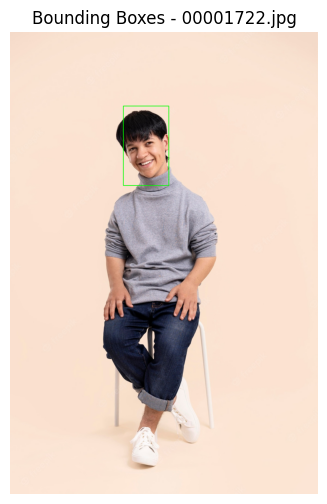

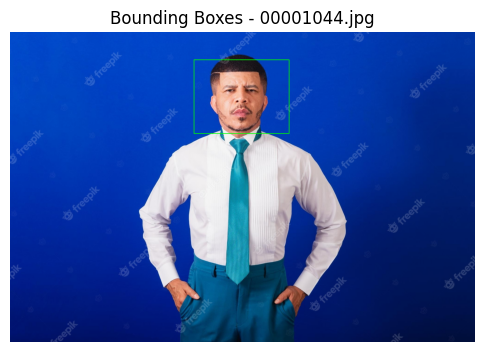

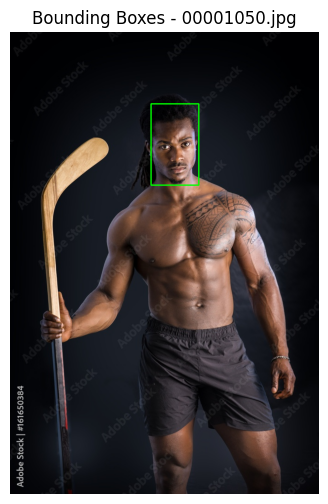

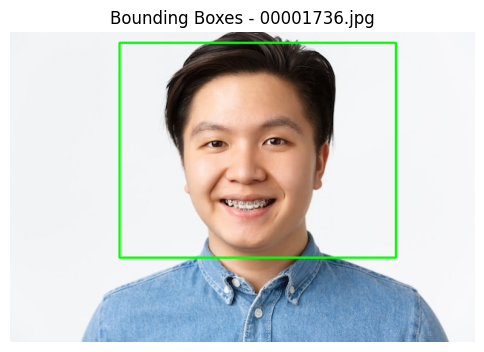

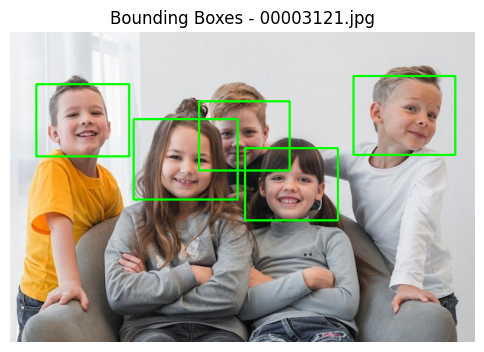

In [11]:
# 3. Bounding Box Accuracy – Visual Check
# Number of images to check visually
# Show Multiple Sample Bounding Boxes
sample_images = df['image_name'].unique()[:5]  # first 5 unique images

for img_name in sample_images:
    # Filter all rows (faces) for that image
    face_rows = df[df['image_name'] == img_name]

    # Load and convert image to RGB
    img_path = os.path.join(RAW_IMG_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Image not found: {img_name}")
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Draw all bounding boxes for that image
    for _, row in face_rows.iterrows():
        x0, y0, x1, y1 = int(row['x0']), int(row['y0']), int(row['x1']), int(row['y1'])
        cv2.rectangle(img_rgb, (x0, y0), (x1, y1), (0, 255, 0), 2)

    # Show the image with all boxes
    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Bounding Boxes - {img_name}")
    plt.axis('off')
    plt.show()

In [12]:
# 4. Label Consistency Check
# What: Ensure bounding box columns are valid
# Why: Detect errors like negative coordinates, x0 > x1, etc.
invalid_boxes = df[(df['x0'] >= df['x1']) | (df['y0'] >= df['y1'])]
print(f"Invalid bounding box rows: {len(invalid_boxes)}")

if len(invalid_boxes) > 0:
    display(invalid_boxes.head())

Invalid bounding box rows: 0


Original resolution stats:
             width       height
count  3350.000000  3350.000000
mean    967.967164   829.165373
std     651.959869   604.168252
min     150.000000   115.000000
25%     612.000000   433.000000
50%     800.000000   683.000000
75%    1200.000000  1024.000000
max    8192.000000  6680.000000


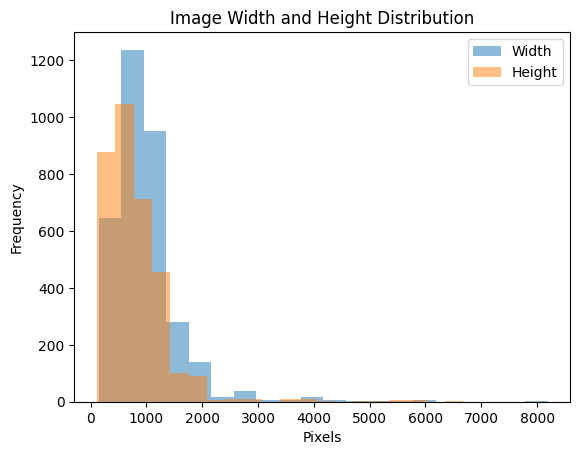

In [13]:
# 5. Resize Requirement
# What: Are all images roughly the same size?
# Why: Detect extreme size variations
print("Original resolution stats:")
print(df[['width', 'height']].describe())

# Optional: Check histogram
plt.hist(df['width'], bins=20, alpha=0.5, label='Width')
plt.hist(df['height'], bins=20, alpha=0.5, label='Height')
plt.legend()
plt.title("Image Width and Height Distribution")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()

In [14]:
# Conclusion for above diagram
# Problem:
# Very small images (<200×200): likely too low-quality for facial detection
# Very large images (>3000×3000): may cause memory overload and slow processing
# I dont do any changes, i leave it as it is.

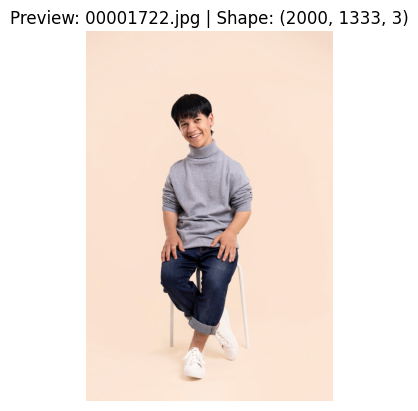

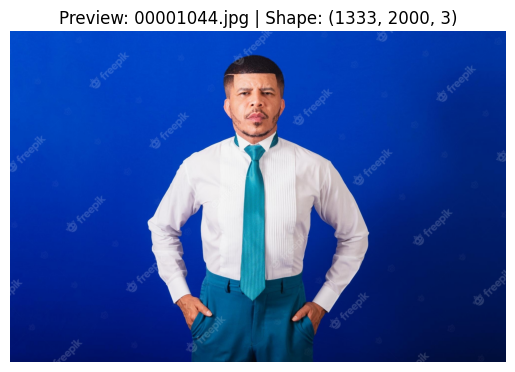

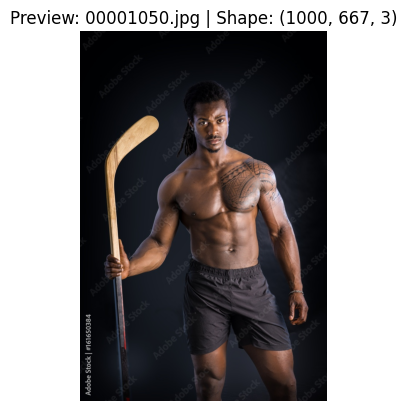

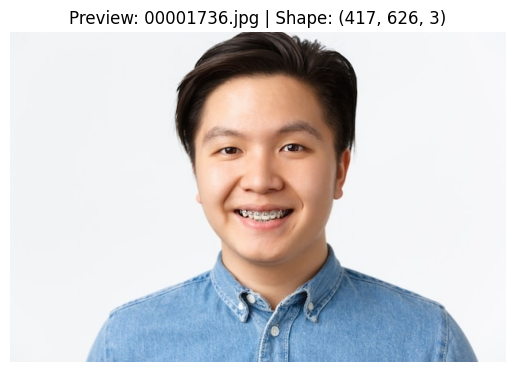

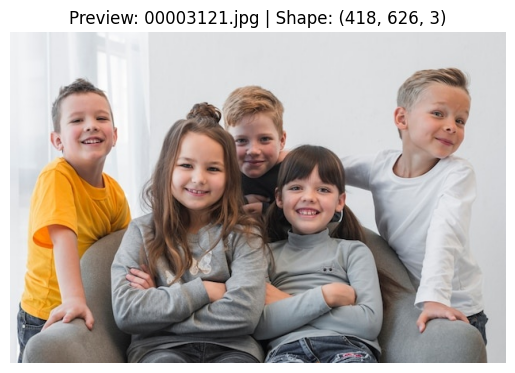

In [15]:
# 6. Resolution Clarity Check (Manual)
# Pick a few images and display them to visually verify clarity.
for name in df['image_name'].unique()[:5]:  # First 5 images
    img_path = os.path.join(RAW_IMG_DIR, name)
    img = cv2.imread(img_path)
    if img is not None:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Preview: {name} | Shape: {img.shape}")
        plt.axis('off')
        plt.show()

## Step 3: Feature Engineering

In [16]:
# 1. Bounding Box Coordinates
# Bounding box coordinates are already in your CSV and define the face region.
# Already available in your DataFrame
df[['x0', 'y0', 'x1', 'y1']].head()
# You’ll use these as ground truth labels during model training.

x0   y0    x1   y1
0  490  320   687  664
1  791  119  1200  436
2  304  155   407  331
3  147   14   519  303
4  462   60   599  166


 MediaPipe Face Landmark Detection (on Cropped Faces):

Processing 00001722.jpg – Faces: 1


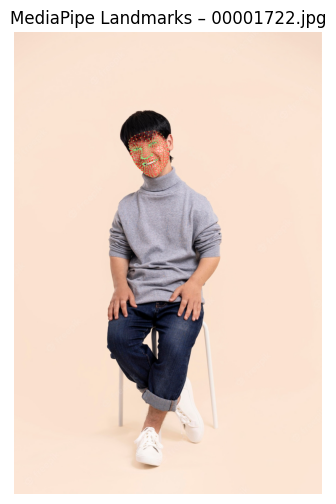

Processing 00001044.jpg – Faces: 1


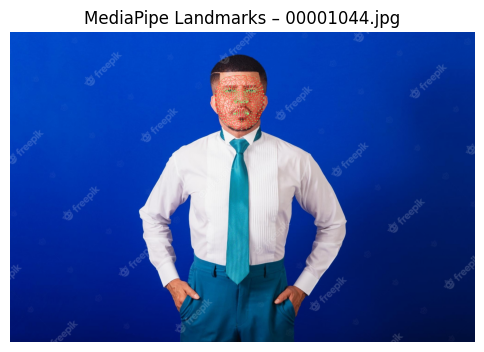

Processing 00001050.jpg – Faces: 1


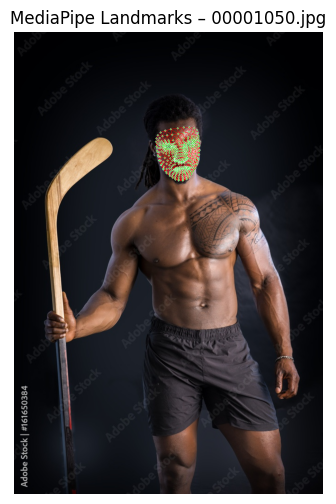

Processing 00001736.jpg – Faces: 1


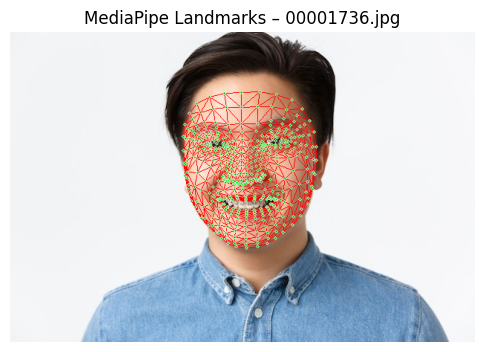

Processing 00003121.jpg – Faces: 5


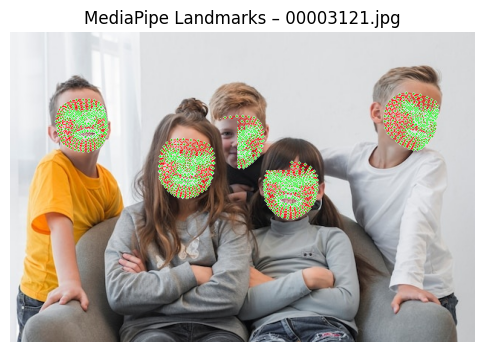

In [17]:
# 2.Face Detection and Face Landmark Visualizer using MediaPipe and CSV
# If your current dataset doesn’t include landmark coordinates, you can extract them using libraries like:
# mediapipe (Google's face mesh API)
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import mediapipe as mp

# Setup 
RAW_IMG_DIR = "raw_images"
CSV_PATH = "faces.csv"

# Load CSV and pick first 5 unique images
df = pd.read_csv(CSV_PATH)
sample_images = df['image_name'].unique()[:5]  # Same 5 used for both visualizations

# === MediaPipe FaceMesh on Cropped Faces ===
print("\n MediaPipe Face Landmark Detection (on Cropped Faces):\n")
mp_face_mesh = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

with mp_face_mesh.FaceMesh(
    static_image_mode=True,
    refine_landmarks=True,
    max_num_faces=1,
    min_detection_confidence=0.5
) as face_mesh:

    for img_name in sample_images:
        group = df[df['image_name'] == img_name]
        img_path = os.path.join(RAW_IMG_DIR, img_name)
        full_img = cv2.imread(img_path)

        if full_img is None:
            print(f"Could not read {img_name}")
            continue

        display_img = full_img.copy()
        print(f"Processing {img_name} – Faces: {len(group)}")

        for _, row in group.iterrows():
            x0, y0, x1, y1 = map(int, [row['x0'], row['y0'], row['x1'], row['y1']])
            face_crop = full_img[y0:y1, x0:x1]

            if face_crop.size == 0:
                continue

            face_rgb = cv2.cvtColor(face_crop, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(face_rgb)

            if results.multi_face_landmarks:
                for landmarks in results.multi_face_landmarks:
                    mp_drawing.draw_landmarks(
                        image=face_rgb,
                        landmark_list=landmarks,
                        connections=mp_face_mesh.FACEMESH_TESSELATION,
                        landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=1, circle_radius=1),
                        connection_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=1)
                    )
                display_img[y0:y1, x0:x1] = cv2.cvtColor(face_rgb, cv2.COLOR_RGB2BGR)
            else:
                print(f"No face detected in region: ({x0},{y0},{x1},{y1})")

        plt.figure(figsize=(6, 6))
        plt.imshow(cv2.cvtColor(display_img, cv2.COLOR_BGR2RGB))
        plt.title(f"MediaPipe Landmarks – {img_name}")
        plt.axis('off')
        plt.show()

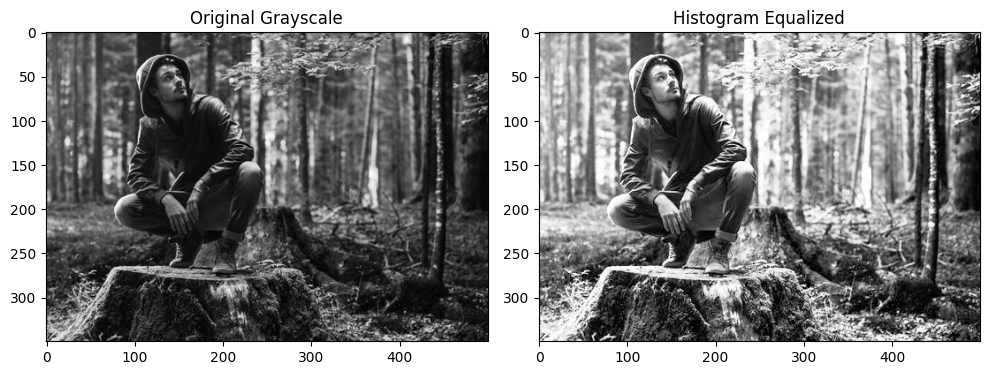

In [18]:
# 3. Histogram Equalization (for contrast improvement — only for grayscale images)
# Even though MediaPipe uses RGB, here’s the visualization code to understand how it works:
import cv2
import matplotlib.pyplot as plt

img_path = "raw_images/00000003.jpg"
img = cv2.imread(img_path)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
equalized = cv2.equalizeHist(gray)

# Plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap='gray')
plt.title("Original Grayscale")

plt.subplot(1, 2, 2)
plt.imshow(equalized, cmap='gray')
plt.title("Histogram Equalized")

plt.tight_layout()
plt.show()
# Usage in your project: Not recommended for MediaPipe. Just use for EDA or report visuals.

In [19]:
# 4. Normalization (for CNN models)
# You can normalize the cropped face before sending to MediaPipe (not mandatory, but useful if you later switch to your own CNN).
img = cv2.imread("raw_images/00000003.jpg")
img = cv2.resize(img, (224, 224))  # if needed
img_normalized = img / 255.0

print(f"Pixel Range After Normalization: {img_normalized.min()} – {img_normalized.max()}")
# MediaPipe handles this internally, so skip this in your MediaPipe pipeline, but use if you build your own CNN in the future.

Pixel Range After Normalization: 0.0 – 0.996078431372549


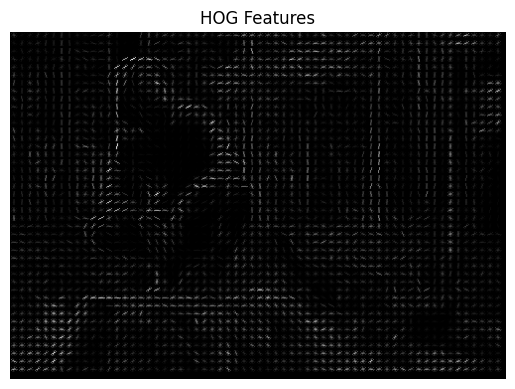

HOG Feature Vector Size: (92232,)


In [20]:
# 5. HOG (Histogram of Oriented Gradients)
# Good for visualization or if you want to compare it with landmark features.
# pip install scikit-image
from skimage.feature import hog
from skimage import color
import matplotlib.pyplot as plt

img = cv2.imread("raw_images/00000003.jpg")
gray = color.rgb2gray(img)  # scikit-image expects float RGB

features, hog_image = hog(gray,
                          orientations=9,
                          pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2),
                          visualize=True,
                          block_norm='L2-Hys')

# Display
plt.imshow(hog_image, cmap='gray')
plt.title("HOG Features")
plt.axis('off')
plt.show()

print("HOG Feature Vector Size:", features.shape)
# Optional: Use if you're comparing traditional features vs. deep features.

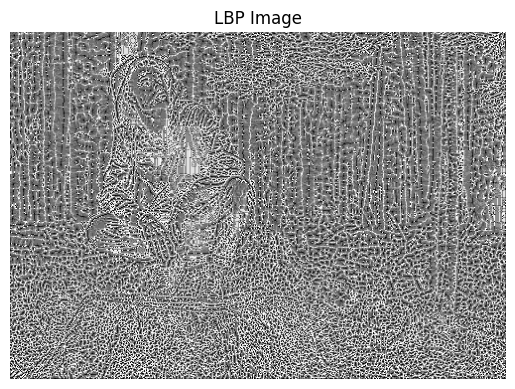

In [21]:
# 6. LBP (Local Binary Patterns)
# Similar to HOG — useful in facial texture analysis or feature experiments.
from skimage.feature import local_binary_pattern

img = cv2.imread("raw_images/00000003.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

radius = 1
n_points = 8 * radius

lbp = local_binary_pattern(gray, n_points, radius, method='uniform')

plt.imshow(lbp, cmap='gray')
plt.title("LBP Image")
plt.axis('off')
plt.show()

## Step 4: Split Data into Training and Test Sets

In [22]:
# Train-Test Split for Face Detection
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your full annotation file
df = pd.read_csv("faces.csv")

# Perform stratified split based on image_name to ensure face diversity
unique_images = df['image_name'].unique()
train_imgs, test_imgs = train_test_split(unique_images, test_size=0.2, random_state=42)

# Split the original dataframe
train_df = df[df['image_name'].isin(train_imgs)].reset_index(drop=True)
test_df = df[df['image_name'].isin(test_imgs)].reset_index(drop=True)

# Save or use directly
train_df.to_csv("train_faces.csv", index=False)
test_df.to_csv("test_faces.csv", index=False)

print(f"Train images: {len(train_imgs)}, Faces: {len(train_df)}")
print(f"Test images : {len(test_imgs)}, Faces: {len(test_df)}")

Train images: 1763, Faces: 2686
Test images : 441, Faces: 664


# Step 5: Choose a Classification Model

In [23]:
# Step 1: Convert faces.csv to YOLO Format
# Each bounding box in YOLO format is:
# [class_id x_center y_center width height]
# All values normalized by image width and height.
# Convert and Split into Train/Val:
import os
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split

# Paths
RAW_IMG_DIR = "raw_images"
CSV_PATH = "faces.csv"
YOLO_LABEL_DIR = "labels"
YOLO_IMG_DIR = "images"

# Create directories
for subset in ['train', 'val']:
    os.makedirs(os.path.join(YOLO_LABEL_DIR, subset), exist_ok=True)
    os.makedirs(os.path.join(YOLO_IMG_DIR, subset), exist_ok=True)

# Load CSV
df = pd.read_csv(CSV_PATH)

# Split into train and validation sets (80-20 split by image)
unique_imgs = df['image_name'].unique()
train_imgs, val_imgs = train_test_split(unique_imgs, test_size=0.2, random_state=42)

# Group for easy access
img_groups = df.groupby('image_name')

def convert_and_save_yolo(img_name, subset):
    rows = img_groups.get_group(img_name)

    # Load image to get size
    img_path = os.path.join(RAW_IMG_DIR, img_name)
    img = cv2.imread(img_path)
    if img is None:
        print(f"Skipping missing image: {img_name}")
        return

    h, w = img.shape[:2]

    # Save image to YOLO folder
    cv2.imwrite(os.path.join(YOLO_IMG_DIR, subset, img_name), img)

    # Prepare label file
    label_lines = []
    for _, row in rows.iterrows():
        x0, y0, x1, y1 = row['x0'], row['y0'], row['x1'], row['y1']
        x_center = (x0 + x1) / 2 / w
        y_center = (y0 + y1) / 2 / h
        bbox_width = (x1 - x0) / w
        bbox_height = (y1 - y0) / h

        label_lines.append(f"0 {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}")

    # Save to .txt
    label_path = os.path.join(YOLO_LABEL_DIR, subset, img_name.replace(".jpg", ".txt"))
    with open(label_path, "w") as f:
        f.write("\n".join(label_lines))

# Process all images
for img_name in train_imgs:
    convert_and_save_yolo(img_name, "train")

for img_name in val_imgs:
    convert_and_save_yolo(img_name, "val")

print("YOLO annotation and split complete!")

YOLO annotation and split complete!


In [24]:
# Step 2: Create data.yaml File(.yaml extension.)
# Save this file as data.yaml in your project folder:
# path:  "F:/FINAL_PROJECT_HFOD" # root folder path
# train: images/train
# val: images/val

# nc: 1
# names: ['face']

# Step 6: Train the Model

In [25]:
# Train YOLO (Recommended: YOLOv8)
# YOLOv8 is from Ultralytics and simpler to use than earlier versions:

# Step 1: Install Ultralytics (YOLOv8)

%pip install ultralytics

Note: you may need to restart the kernel to use updated packages.


In [27]:
# Step 2: Run YOLO Training 
from ultralytics import YOLO

# Load the lightweight YOLOv8 Nano model (best for CPU)
model = YOLO("yolov8n.pt")

# Train the model with optimized settings
model.train(
    data="F:/FINAL_PROJECT_HFOD/data.yaml",  # Your dataset config path
    epochs=30,            # Start with 10 epochs to reduce time
    imgsz=416,            # Smaller image size to speed up training
    device='cpu',         # Explicitly use CPU
    batch=4,              # Smaller batch size for CPU memory efficiency
    workers=0,            # Prevent multi-threading issues on some CPUs
    patience=5            # Stop if no improvement after 5 epochs
)

Ultralytics 8.3.169  Python-3.12.5 torch-2.7.1+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=4, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=F:/FINAL_PROJECT_HFOD/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=5, perspective=0.0, plots=True, pose=12.0, pret

train: Scanning F:\FINAL_PROJECT_HFOD\labels\train.cache... 1763 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1763/1763 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 7.74.3 MB/s, size: 123.6 KB)



f:\FINAL_PROJECT_HFOD\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning F:\FINAL_PROJECT_HFOD\labels\val.cache... 441 images, 0 backgrounds, 0 corrupt: 100%|██████████| 441/441 [00:00<?, ?it/s]

Plotting labels to runs\detect\train3\labels.jpg... 



f:\FINAL_PROJECT_HFOD\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 0 dataloader workers
Logging results to runs\detect\train3
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30         0G       1.75       1.93      1.627          5        416: 100%|██████████| 441/441 [13:06<00:00,  1.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [01:13<00:00,  1.31s/it]


                   all        441        664       0.75       0.75      0.797      0.376

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30         0G      1.581      1.564      1.539          9        416: 100%|██████████| 441/441 [1:04:56<00:00,  8.84s/it]  
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:53<00:00,  1.04it/s]


                   all        441        664      0.738       0.83      0.837      0.447

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30         0G       1.55      1.449      1.528         10        416: 100%|██████████| 441/441 [22:58<00:00,  3.13s/it]    
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


                   all        441        664       0.62      0.794      0.734      0.367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30         0G      1.501      1.343      1.484          4        416: 100%|██████████| 441/441 [11:02<00:00,  1.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.19it/s]


                   all        441        664      0.769      0.798       0.84      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30         0G       1.49      1.288      1.476          5        416: 100%|██████████| 441/441 [11:07<00:00,  1.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.18it/s]

                   all        441        664      0.813      0.902      0.905      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30         0G      1.431      1.241      1.435          6        416: 100%|██████████| 441/441 [11:10<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.18it/s]

                   all        441        664      0.762      0.852      0.812       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30         0G      1.407      1.175      1.416          8        416: 100%|██████████| 441/441 [11:17<00:00,  1.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.18it/s]

                   all        441        664        0.8      0.849      0.889      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30         0G       1.35      1.113      1.375          9        416: 100%|██████████| 441/441 [11:15<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:46<00:00,  1.20it/s]

                   all        441        664      0.812      0.931      0.909       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30         0G      1.351      1.085        1.4          3        416: 100%|██████████| 441/441 [11:13<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.18it/s]

                   all        441        664      0.788      0.913      0.824      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30         0G      1.313       1.06      1.356          5        416: 100%|██████████| 441/441 [11:10<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.18it/s]


                   all        441        664      0.841      0.878      0.917      0.584

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30         0G      1.298      1.036      1.345         16        416: 100%|██████████| 441/441 [11:35<00:00,  1.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.19it/s]

                   all        441        664       0.84       0.88      0.906        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30         0G      1.265      1.018      1.329          7        416: 100%|██████████| 441/441 [11:13<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:46<00:00,  1.20it/s]

                   all        441        664      0.849      0.916      0.934      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30         0G      1.274     0.9952      1.323         10        416: 100%|██████████| 441/441 [11:12<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.19it/s]

                   all        441        664      0.824      0.947      0.917      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30         0G      1.226     0.9837      1.302          4        416: 100%|██████████| 441/441 [11:08<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:46<00:00,  1.19it/s]

                   all        441        664       0.83      0.925      0.934      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30         0G      1.209      0.961      1.308          7        416: 100%|██████████| 441/441 [11:14<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.18it/s]

                   all        441        664      0.859      0.937      0.941      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30         0G      1.206     0.9352       1.29         14        416: 100%|██████████| 441/441 [11:14<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.18it/s]

                   all        441        664      0.842      0.953      0.927      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30         0G      1.212      0.915      1.297         10        416: 100%|██████████| 441/441 [11:10<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.18it/s]

                   all        441        664      0.806        0.9      0.889      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30         0G      1.189     0.9222      1.287         19        416: 100%|██████████| 441/441 [11:09<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.19it/s]

                   all        441        664      0.873      0.908      0.941      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30         0G       1.17     0.8846      1.278         10        416: 100%|██████████| 441/441 [11:15<00:00,  1.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:47<00:00,  1.19it/s]

                   all        441        664      0.857      0.921      0.943      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30         0G      1.156     0.8859      1.262         11        416: 100%|██████████| 441/441 [11:09<00:00,  1.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:46<00:00,  1.19it/s]

                   all        441        664      0.852      0.941      0.945      0.645
EarlyStopping: Training stopped early as no improvement observed in last 5 epochs. Best results observed at epoch 15, best model saved as best.pt.
To update EarlyStopping(patience=5) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



20 epochs completed in 5.138 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.2MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.169  Python-3.12.5 torch-2.7.1+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 56/56 [00:40<00:00,  1.39it/s]


                   all        441        664      0.859      0.938      0.941      0.658
Speed: 1.2ms preprocess, 70.0ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs\detect\train3


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000012DECAA1730>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

 # Step 7: Evaluate Model Performance with YOLOv8

In [33]:
# Once your training is completed and the model is saved (e.g., best.pt), follow these actions:

# 1. Load the Best Model
from ultralytics import YOLO

# Load your trained model
model = YOLO("runs/detect/train3/weights/best.pt")

In [37]:
# 2. Evaluate the Model on the Validation Set:
# Run evaluation
metrics = model.val()

# Mean Average Precision
print(f"mAP50-95: {metrics.box.map:.4f}")     # mAP@0.5:0.95
print(f"mAP50: {metrics.box.map50:.4f}")      # mAP@0.5

# Precision and Recall per class
precision = metrics.box.p     # list of precision values per class
recall = metrics.box.r        # list of recall values per class

# Print average precision and recall
print(f"Precision: {sum(precision)/len(precision):.4f}")   
print(f"Recall: {sum(recall)/len(recall):.4f}")            

Ultralytics 8.3.169  Python-3.12.5 torch-2.7.1+cpu CPU (Intel Core(TM) i5-7200U 2.50GHz)
val: Fast image access  (ping: 0.10.0 ms, read: 517.9415.4 MB/s, size: 616.0 KB)


val: Scanning F:\FINAL_PROJECT_HFOD\labels\val.cache... 441 images, 0 backgrounds, 0 corrupt: 100%|██████████| 441/441 [00:00<?, ?it/s]
f:\FINAL_PROJECT_HFOD\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 28/28 [00:57<00:00,  2.04s/it]


                   all        441        664      0.863      0.937      0.942      0.658
Speed: 1.1ms preprocess, 105.3ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs\detect\val
mAP50-95: 0.6578
mAP50: 0.9423
Precision: 0.8630
Recall: 0.9367


In [ ]:
# These metrics will help you understand:
# Precision: How many predicted boxes were correct.
# Recall: How many ground truth boxes were detected.
# mAP (mean Average Precision): Overall accuracy across IoU thresholds.

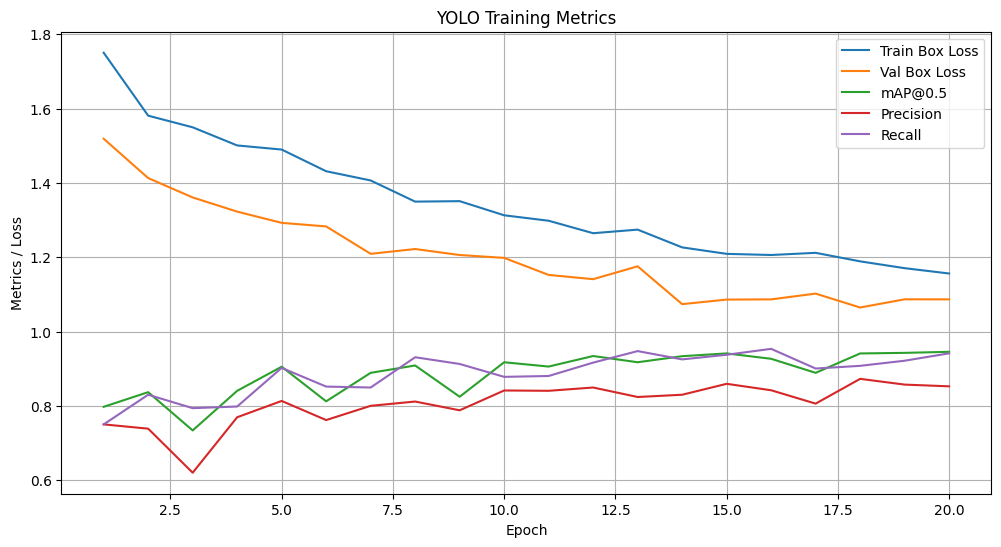

In [41]:
# 3. Check for Overfitting:
# Compare training and validation performance using the generated files:
# Inside runs/detect/train/, open:
# results.csv: It shows training vs validation loss, precision, recall, and mAP over epochs.

# Interpretation:
# If training loss continues to go down while validation mAP stagnates or drops → possible overfitting.
# If training and validation performance curves are aligned → healthy model.

# Plot the CSV over all epochs(Check for Overfitting):
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(12, 6))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")

# Plot metrics using correct column names
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")

# Final plot settings
plt.xlabel("Epoch")
plt.ylabel("Metrics / Loss")
plt.title("YOLO Training Metrics")
plt.legend()
plt.grid(True)
plt.show()

# Check for this pattern:
# Training loss keeps decreasing
# Validation loss starts increasing → Overfitting!
# mAP50, Precision, or Recall plateau or drop → Overfitting!